# Retail Agent Demo

### Import + API Keys
First, we want to configure our API keys and handle all of our imports

In [10]:
import os
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
from langchain.agents import Tool, initialize_agent, AgentType
import difflib
import matplotlib.pyplot as plt
from dotenv import load_dotenv

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')


### Constants + Data + Model

1. Our confidence threshold is for the image recognition confirmation.
2. Our stock data is a AI generated list of items, descriptions, and whether they're in stock.
3. Our model is a pre-trained basic image recognition model, trained on imagenet. A Google Vision model or something else would be better, but those get expensive fast.

In [11]:
CONFIDENCE_THRESHOLD = .3

# ChatGPT generated stock.csv
stock_data = pd.read_csv('stock.csv')

# Pre-trained MobileNetV2 model
model = tf.keras.applications.MobileNetV2(weights='imagenet')

### Image Helpers

1. We want to preprocess our image so that we can get accurate predictions from our Tensorflow model.
2. Let's get our predicted classes from the tensorflow model.
3. Since we're using a pre-trained model, we need to match the imagenet labels to ours. We go through each to try and match. If the confidence is less than the confidence threshold, we confirm with the user that is indeed a picture of x.

In [12]:
def match_image_to_description(image_path, debug=False):
    if not os.path.isfile(image_path):
        return "Image file not found."

    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize for MobileNetV2
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    class_label = tf.keras.applications.mobilenet_v2.decode_predictions(predictions)[0]

    # Add debug for in class demo
    if debug == True:

        #Simple plt chart for demo
        labels = [item[1] for item in class_label]
        values = [item[2] for item in class_label]

        plt.bar(labels, values)

        plt.title('Bar Chart of Object Detection Scores')
        plt.xlabel('Object Types')
        plt.ylabel('Detection Score')

        plt.show()
    
    # Search in the DataFrame for a match
    for label in class_label:
        class_label_name = label[1].replace('_', ' ').lower()
        confidence_score = label[2]
        matched_row = stock_data[
            stock_data['item_name'].str.contains(class_label_name, case=False, na=False)
        ]
        if not matched_row.empty:
            if confidence_score < CONFIDENCE_THRESHOLD:
                # Ask for user confirmation
                user_input = input(f"I found a match for '{class_label_name}' with confidence {confidence_score:.2f}. "
                        f"Are you sure this is a picture of {matched_row['item_name'].values[0]}? (yes/no)")
                
                if user_input == "no":
                    continue
                else:
                    print(f"MATCHED ROW {matched_row}")
                    return [matched_row['item_name'].values[0], confidence_score]
            else:
                print(f"MATCHED ROW {matched_row}")
                return [matched_row['item_name'].values[0], confidence_score]
    print("NONE FOUND")
    return "No matching description found."




### Check Stock

1. User input may be a little fuzzy compared to the real name, so we use difflib to get the closest matches, with a cutoff of .7.
2. Check if that item is in stock, then return the name, price, and stock status.
3. The name may be different than the entered name (ex: "A monitor" may change to "Monitor" after matching).

In [13]:
def check_stock(item_name):
    """Check if the item is in stock and return a tuple of (price, is_in_stock)."""
    print(f"ITEM NAME: {item_name}")
    
    # Check for an exact match first
    item = stock_data[stock_data['item_name'].str.lower() == item_name.lower()]  # Match case-insensitively
    
    #ideal situation, immediately matches
    if not item.empty:
        in_stock = item['in_stock'].values[0] > 0
        price = item['price'].values[0]
        return item_name, price, in_stock
    
    print("LOOKING FOR CLOSE MATCHES")
    # If exact match is not found, look for close matches
    all_item_names = stock_data['item_name'].str.lower().tolist()  # Get all item names in lowercase
    closest_matches = difflib.get_close_matches(item_name.lower(), all_item_names, n=3, cutoff=0.7)
    print(f"CLOSEST MATCHES: {closest_matches}")
    
    if closest_matches:
        closest_item = closest_matches[0]
        item = stock_data[stock_data['item_name'].str.lower() == closest_item]  # Find the matched item in stock.csv
        
        if not item.empty:
            in_stock = item['in_stock'].values[0] > 0
            price = item['price'].values[0]
            name = item['item_name'].values[0]
            print("RETURNING PRICE, IN STOCK")
            return name, price, in_stock
    
    return item_name, 0, False  # Item not found, give up

### Recommend using GPT

- If an item isn't in stock, we should recommend something else.
- Get a list of all in stock items.
- Give that list to GPT, alongside the desired item.
- Let GPT recommend something to the user, preferrably 3 items.

**NOTE:** Tendency to hallucinate and give items that aren't there.

In [14]:
def recommend_from_csv(item_name):
    # Filter for in-stock items only
    in_stock_items = stock_data[stock_data['in_stock'] == 1][['item_name', 'price', 'description']]
    
    # Check if there are any in-stock items
    if in_stock_items.empty:
        return "No similar items available in stock."

    # Get the list of items into an easy to read input for LLM
    item_list = "\n".join([f"{row['item_name']} (${row['price']}): {row['description']}" for _, row in in_stock_items.iterrows()])
    
    # Kind of big, but only way to get it to work (most of the time)
    recommendation_prompt = PromptTemplate(
        input_variables=["item_name", "item_list"],
        template=("The item {item_name} is out of stock. Here is a list of items in stock:\n{item_list}\n"
                  "Can you recommend a similar item? It is REQUIRED to only recommend in stock items provided.It is REQUIRED to only recommend in stock items provided."
                  "DO NOT UNDER ANY CIRCUMSTANCES RECOMMEND ITEMS NOT IN PROVIDED. IT IS NOT ALLOWED AT ALL EVER"
                  "Recommendations SHOULD be in a similar category"
                  "You do not have to provide 3 recommendations if you can't think of three."
                  "Recommendations should be in descending order by usefulness."
                    "Recommend items in following format: Recommendations:"
                  "\n 1: Recommendation 1, Reasoning\n"
                  "2. Recommendation 2, Reasoning\n 3. Recommendation 3, Reasoning")
    )
    
    openai_llm = OpenAI(temperature=0.7)
    recommendation = recommendation_prompt.format(item_name=item_name, item_list=item_list)
    response = openai_llm(recommendation)
    
    return response

In [15]:
def purchase_item(input_text):
    # Extract item name and price from the input
    item_name, price = input_text.split(", ")
    order_confirmation = input(f"The item '{item_name}' is in stock at {price}. Would you like to order it? (yes/no): ").strip().lower()
    
    if order_confirmation == 'yes':
        return f"Great! Your order for '{item_name}' has been placed."
    else:
        return "No problem! Let me know if you need anything else."

# Small helper function for checkstock, the lambda function in the tools was getting a little complicated
def check_stock_func(input_text):
    result = check_stock(input_text)
    if result[2]:
        return (f"The item '{result[0]}' is IN STOCK at ${result[1]}. You MUST now run the purchaseItem tool. "
                "Include the dollar sign from this when passing to purchaseItem. Do NOT RECOMMEND ANY OTHER ITEMS.")
    else:
        return f"The item '{result[0]}' is OUT OF STOCK. RECOMMEND ANOTHER ITEM BASED on {result[0]}?"


### Give LangChain Agent our Tools

- Now, we create our tools in the right format using our functions above.
- Then, we create an agent, with llm = OpenAI.

In [16]:
tools = [
    Tool(
        name="CheckStock",
        func=check_stock_func,
        description="Check if a specific item is in stock based on the product name. Use this when the user types an item name, requests the stock status, or asks for a price check on a particular product."
    ),
    Tool(
        name="Image Classifier",
        func=lambda input_image: (
            result := match_image_to_description(input_image),
            "I'm sorry, I couldn't find a matching item for the image provided. Apologize to the user and then try to start over." 
            if result == "No matching description found."
            else result
        ),
        description=("Identify an item from an uploaded image and match it to available stock. "
                     "Use this when the user provides a photo, image, or visual description, or requests help identifying an item based on an image. "
                     "Do not use this unless the user uploads a photo.")
    ),
    Tool(
        name="Recommend Item",
        func=lambda input_text: recommend_from_csv(input_text),
        description="Recommend a similar item if the requested item is out of stock."
        "Use this when the Check Stock returns out of stock."
    ),
    Tool(
        name="PurchaseItem",
        func=lambda input_text: purchase_item(input_text),
        description="Prompt the user to confirm a purchase for an in-stock item, using a format 'item_name, price'. Only use this function for IN STOCK items"
    ), 
    #Should be kind of a "catch-all" for general failure. Actual error handling would be a nice improvement.
    Tool(
        name="Restart Chatbot",
        func=lambda _: "I'm really sorry, but I couldn't find a match. Let's start over. Please type an item name, provide an image path, or type 'human' to quit and talk to a human.",
        description="Apologizes to the user when no matching description is found or something goes wrong and you don't know what to do and prompts to restart the chatbot."
    )
]

agent_executor = initialize_agent(
    tools=tools,
    llm=OpenAI(temperature=0.4), #Could use some adjusting
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

### Chatbot Logic:

- Here we have a lot of chatbot logic.
- It's important to note that in a **true** LangChain application, a lot of this would be handled by a model. For simplicity's sake, this works.
- There were some problems I experienced with giving the agent more freedom.

In [17]:
def chatbot():
    print("Welcome to the Stock Checker Chatbot!")
    while True:
        user_input = input("Please type an item name, provide an image path, or type 'human' to quit and talk to a human: ").strip().lower()
        
        if user_input == 'human':
            print("Thank you for using the Stock Checker Chatbot. Goodbye!\n")
            print("Connecting you to a human!")
            break

        # Pass all inputs directly to the agent executor, instead of if statement mess from earlier
        response = agent_executor.run(user_input)
        print(response)

### Example Output for Image Classification from Pretrained model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


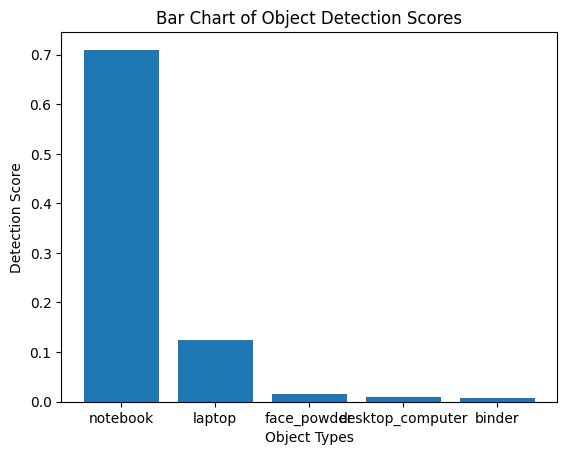

MATCHED ROW   item_name  in_stock   price     category  \
0    Laptop         1  999.99  Electronics   

                                         description  
0  High-performance laptop suitable for work and ...  


['Laptop', 0.12517011]

In [18]:
#Example to show how image classification is working
match_image_to_description('C:\\Users\\histo\\retail_agent_demo\\71EVBJVMSoL.jpg', debug=True)

In [19]:
# Run the chatbot
if __name__ == "__main__":
    chatbot()

Welcome to the Stock Checker Chatbot!


C:\Users\histo\AppData\Local\Temp\ipykernel_22664\2909687809.py:12: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent_executor.run(user_input)




> Entering new AgentExecutor chain...
 The user is requesting information about a specific item, so I should use the CheckStock tool.
Action: CheckStock
Action Input: laptopITEM NAME: laptop

Observation: The item 'laptop' is IN STOCK at $999.99. You MUST now run the purchaseItem tool. Include the dollar sign from this when passing to purchaseItem. Do NOT RECOMMEND ANY OTHER ITEMS.
Thought: I should prompt the user to confirm a purchase using the PurchaseItem tool.
Action: PurchaseItem
Action Input: laptop, $999.99
Observation: Great! Your order for 'laptop' has been placed.
Thought: I now know the final answer.
Final Answer: 'laptop' is in stock and the user has confirmed a purchase for it at $999.99.

> Finished chain.
'laptop' is in stock and the user has confirmed a purchase for it at $999.99.


> Entering new AgentExecutor chain...
 Since the input is an image, I should use the Image Classifier function.
Action: Image Classifier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step71evbjvmsol.j